Class distribution: Unemployment_Status
0    0.502
1    0.498
Name: proportion, dtype: float64
X shape: (1000, 14)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 494ms/step - accuracy: 0.5000 - loss: 0.8291 - val_accuracy: 0.5000 - val_loss: 0.6945 - learning_rate: 1.0000e-04
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5063 - loss: 0.7966 - val_accuracy: 0.5000 - val_loss: 0.6940 - learning_rate: 1.0000e-04
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4995 - loss: 0.7767 - val_accuracy: 0.5000 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5083 - loss: 0.7674 - val_accuracy: 0.5000 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5080 - loss: 0.7606 - val_accuracy: 0.5000 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5115 - loss: 0.7634 - val_accuracy: 0.5000 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4912 

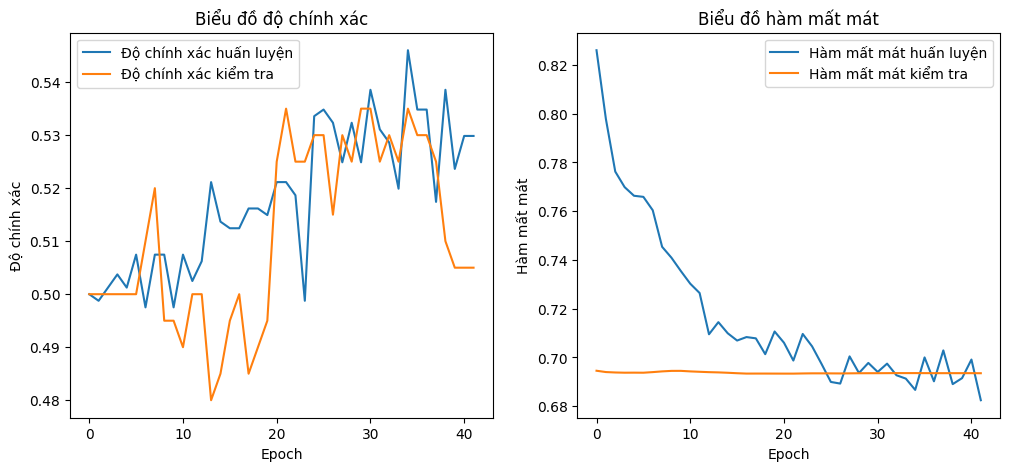

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


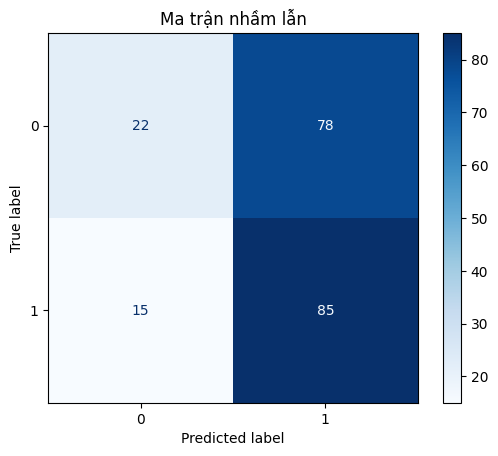

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/sxtk/unemployment_data.csv")

# Define features and target
X = data.drop(columns=["Unemployment_Status"])
y = data["Unemployment_Status"]

# Check class distribution
class_counts = y.value_counts(normalize=True)
print("Class distribution:", class_counts)

# Feature Engineering: Create new features
if "Work_Environment_Satisfaction" in X.columns and "Job_Satisfaction" in X.columns:
    X["Work_Satisfaction"] = X["Work_Environment_Satisfaction"] * X["Job_Satisfaction"]
if "Job_Engagement" in X.columns and "Performance_Rating" in X.columns:
    X["Engagement_Performance"] = X["Job_Engagement"] / (X["Performance_Rating"] + 1)
if "Work_Life_Balance" in X.columns and "Relationship_Satisfaction" in X.columns:
    X["Balance_Satisfaction"] = X["Work_Life_Balance"] * X["Relationship_Satisfaction"]

# Convert categorical features into one-hot encoding if exists
if "Education" in X.columns:
    X = pd.get_dummies(X, columns=["Education"], prefix="Edu")

# Check for missing values
if X.isnull().sum().sum() > 0:
    X.fillna(X.mean(), inplace=True)

print("X shape:", X.shape)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build optimized ANN model
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(512, activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Dense(16, activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Độ chính xác huấn luyện')
plt.plot(history.history['val_accuracy'], label='Độ chính xác kiểm tra')
plt.xlabel('Epoch')
plt.ylabel('Độ chính xác')
plt.legend()
plt.title('Biểu đồ độ chính xác')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Hàm mất mát huấn luyện')
plt.plot(history.history['val_loss'], label='Hàm mất mát kiểm tra')
plt.xlabel('Epoch')
plt.ylabel('Hàm mất mát')
plt.legend()
plt.title('Biểu đồ hàm mất mát')

plt.show()

# Generate confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Ma trận nhầm lẫn')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!pip install gradio


import gradio as gr

# Hàm dự đoán tình trạng thất nghiệp (tạm thời trả về kết quả ngẫu nhiên)
def predict_unemployment(education, experience, industry):
    # Chuyển đổi đầu vào thành số
    education_mapping = {"Cấp 2": 1, "Cấp 3": 2, "Đại học": 3, "Khác": 4}
    experience_mapping = {"1-3 năm": 1, "5-7 năm": 2, "10 năm": 3, "Trên 10 năm": 4}
    industry_mapping = {
        "CNTT": 1, "Tài chính": 2, "Y tế": 3, "Giáo dục": 4, "Xây dựng": 5, "Tự do": 6
    }

    edu = education_mapping[education]
    exp = experience_mapping[experience]
    ind = industry_mapping[industry]

    # Tạm thời dự đoán ngẫu nhiên (thực tế cần dùng mô hình ANN)
    import random
    result = "Thất nghiệp" if random.random() > 0.5 else "Không thất nghiệp"

    return f"Dự đoán: {result}"

# Tạo giao diện người dùng
with gr.Blocks() as demo:
    gr.Markdown("## Dự đoán tình trạng thất nghiệp")

    education = gr.Dropdown(["Cấp 2", "Cấp 3", "Đại học", "Khác"], label="Trình độ học vấn")
    experience = gr.Dropdown(["1-3 năm", "5-7 năm", "10 năm", "Trên 10 năm"], label="Kinh nghiệm")
    industry = gr.Dropdown(["CNTT", "Tài chính", "Y tế", "Giáo dục", "Xây dựng", "Tự do"], label="Ngành nghề")

    predict_button = gr.Button("Dự đoán")
    output = gr.Textbox(label="Kết quả")

    predict_button.click(predict_unemployment, inputs=[education, experience, industry], outputs=output)

# Chạy giao diện
demo.launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://50cf5dc8ae7819b806.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/sp